# <center>Построение адаптивных моделей прогнозирования</center>

In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Исходные данные (объемы пассажирских авиаперевозок)

In [2]:
passengers = pd.read_csv('data/ausair.csv', index_col='Year', parse_dates=True)

In [3]:
passengers.head()

,Passengers
Year,
1970-01-01,7.32
1971-01-01,7.33
1972-01-01,7.80
1973-01-01,9.38
1974-01-01,10.66


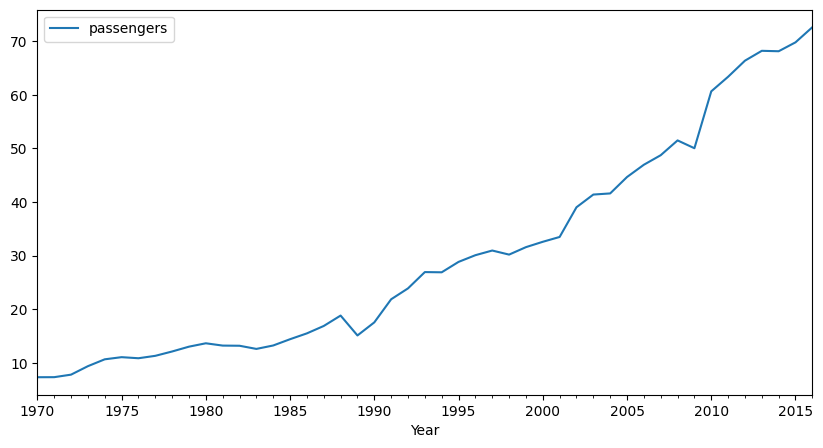

In [4]:
passengers['Passengers'].plot(figsize=(10,5), label='passengers')
plt.legend()
plt.show()

## 1. Простое экспоненциальное сглаживание (метод Брауна)

### 1.1 Аппроксимация исходного ряда методом простого экспоненциального сглаживания

In [144]:
def approximate_BRAUN(alpha=0.9, column='Passengers'):
    level = np.full(passengers.shape[0], 0.)
    level[0] = passengers[column].values[0]
    
    y_hat = np.full(passengers.shape[0], 0.)
    y_hat[0] = level[0]
    
    for i in range(1, passengers.shape[0]):
        level[i] = alpha * passengers[column].values[i] + (1-alpha) * level[i-1]
        y_hat[i] = level[i]

    return y_hat, level

In [145]:
approximation, _ = approximate_BRAUN()
approximation_df = pd.DataFrame(approximation, columns=['Passengers'])
approximation_df.index = passengers.index

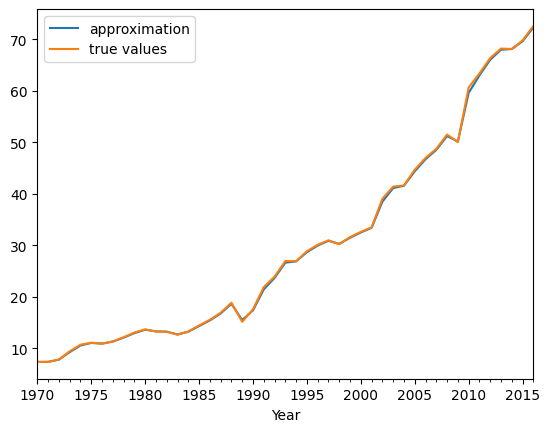

In [146]:
approximation_df['Passengers'].plot(label='approximation')
passengers['Passengers'].plot(label='true values')
plt.legend()
plt.show()

### 1.2 Прогноз на 10 лет с помощью метода простого экспоненциального сглаживания

In [147]:
def get_forecast_BRAUN(alpha=0.9, column='Passengers'):
    y_hat, level = approximate_BRAUN(alpha, column)
    
    for i in range(10):
        level = np.append(level, alpha * y_hat[-1] + (1-alpha) * level[-2])
        y_hat = np.append(y_hat, level[-1])

    return y_hat, level

In [153]:
forecast, _ = get_forecast_BRAUN()
forecast_df = pd.DataFrame(forecast, columns=['Passengers'])
forecast_df.index = passengers.index.append(pd.date_range('2017-01-01', '2027-01-01', freq='Y'))

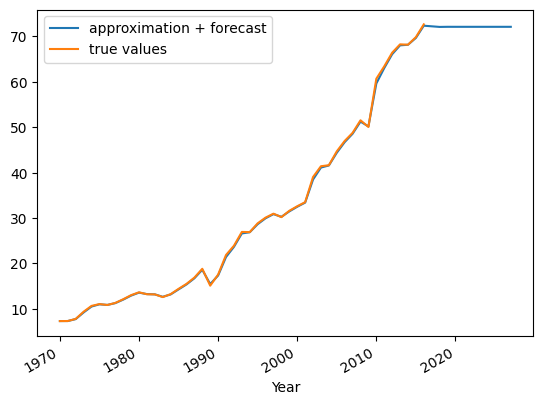

In [155]:
forecast_df['Passengers'].plot(label='approximation + forecast')
passengers['Passengers'].plot(label='true values')
plt.legend()
plt.show()

## 2. Метод Хольта

In [156]:
# в модели скорее экспоненциальный тренд, но мы делаем с линейным

### 2.1 Линейный тренд

#### 2.1.1 Сначала аппроксимация

In [157]:
def approximate_HOLT(alpha=0.59, beta=0.43, column='Passengers'):
    level = np.full(passengers.shape[0], 0.)
    level[0] = passengers[column].values[0]

    trend = np.full(passengers.shape[0], 0.)
    trend[0] = passengers[column].values[1] - passengers[column].values[0]
    
    y_hat = np.full(passengers.shape[0], 0.)
    y_hat[0] = level[0] + trend[0]
    
    for i in range(1, passengers.shape[0]):
        level[i] = (alpha * passengers[column].values[i] + (1-alpha) * (level[i-1] + trend[i-1]))
        trend[i] = beta * (level[i] - level[i-1]) + (1-beta) * trend[i-1]
        y_hat[i] = level[i] + trend[i]

    return y_hat, level, trend

In [158]:
approximation, _, _ = approximate_HOLT()
approximation_df = pd.DataFrame(approximation, columns=['Passengers'])
approximation_df.index = passengers.index

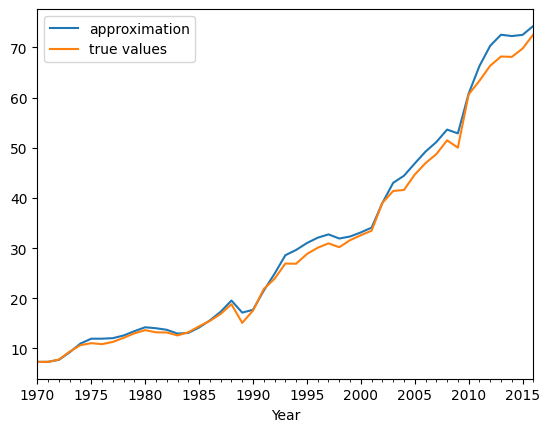

In [159]:
approximation_df['Passengers'].plot(label='approximation')
passengers['Passengers'].plot(label='true values')
plt.legend()
plt.show()

#### 2.1.2 Прогноз

In [201]:
def get_forecast_HOLT(alpha=0.59, beta=0.43, column='Passengers'):
    y_hat, level, trend = approximate_HOLT(alpha, beta, column)
        
    for i in range(1, 11):
        level = np.append(level, alpha * y_hat[-1] + (1-alpha) * (level[-2] + trend[-2]))
        trend = np.append(trend, beta * (level[-1] - level[-2]) + (1-beta) * trend[-2])
        y_hat = np.append(y_hat, level[len(y_hat)-i] + i * trend[len(y_hat)-i])
    return y_hat, level, trend

In [202]:
forecast, _, _ = get_forecast_HOLT()
forecast_df = pd.DataFrame(forecast, columns=['Passengers'])
forecast_df.index = passengers.index.append(pd.date_range('2017-01-01', '2027-01-01', freq='Y'))

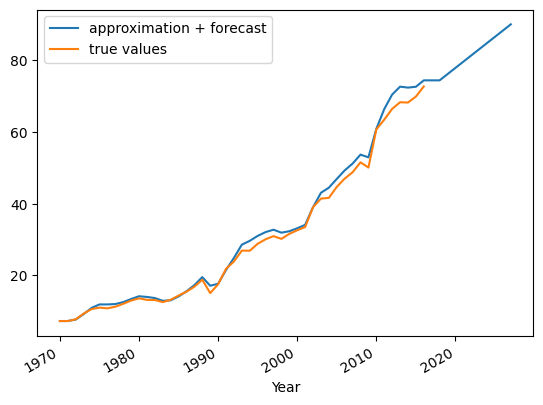

In [203]:
forecast_df['Passengers'].plot(label='approximation + forecast')
passengers['Passengers'].plot(label='true values')
plt.legend()
plt.show()

### 2.2 Аддитивный затухающий тренд

#### 2.2.1 Аппроксимация

In [9]:
def approximate_ADDITIVE_DECAYING_TREND_HOLT(alpha=0.39, beta=0.1, phi=0.9, column='Passengers'):
    level = np.full(passengers.shape[0], 0.)
    level[0] = passengers[column].values[0]

    trend = np.full(passengers.shape[0], 0.)
    trend[0] = passengers[column].values[1] - passengers[column].values[0]
    
    y_hat = np.full(passengers.shape[0], 0.)
    y_hat[0] = level[0] + phi * trend[0]
    
    for i in range(1, passengers.shape[0]):
        level[i] = (alpha * passengers[column].values[i] + (1-alpha) * (level[i-1] + phi * trend[i-1]))
        trend[i] = beta * (level[i] - level[i-1]) + (1-beta) * phi * trend[i-1]
        y_hat[i] = level[i] + phi * trend[i]

    return y_hat, level, trend

In [10]:
approximation, _, _ = approximate_ADDITIVE_DECAYING_TREND_HOLT()
approximation_df = pd.DataFrame(approximation, columns=['Passengers'])
approximation_df.index = passengers.index

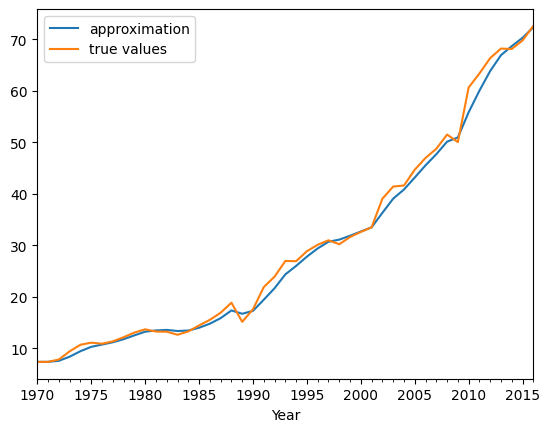

In [11]:
approximation_df['Passengers'].plot(label='approximation')
passengers['Passengers'].plot(label='true values')
plt.legend()
plt.show()

#### 2.2.2 Прогноз

In [20]:
def get_forecast_ADDITIVE_DECAYING_TREND_HOLT(alpha=0.39, beta=0.1, phi=0.9, column='Passengers'):
    y_hat, level, trend = approximate_ADDITIVE_DECAYING_TREND_HOLT(alpha, beta, phi, column)

    damping_sum = 0 
    for i in range(1, 11):
        level = np.append(level, alpha * y_hat[-1] + (1-alpha) * phi * (level[-2] + trend[-2]))
        trend = np.append(trend, beta * (level[-1] - level[-2]) + (1-beta) * phi * trend[-2])
        damping_sum += phi ** i
        y_hat = np.append(y_hat, level[len(y_hat)-i] + damping_sum * trend[len(y_hat)-i])
    return y_hat, level, trend

In [21]:
forecast, _, _ = get_forecast_ADDITIVE_DECAYING_TREND_HOLT()
forecast_df = pd.DataFrame(forecast, columns=['Passengers'])
forecast_df.index = passengers.index.append(pd.date_range('2017-01-01', '2027-01-01', freq='Y'))

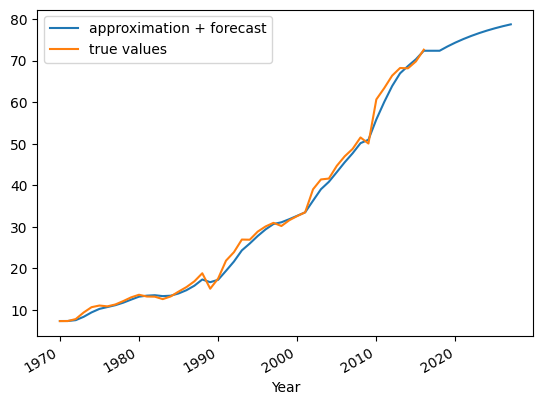

In [22]:
forecast_df['Passengers'].plot(label='approximation + forecast')
passengers['Passengers'].plot(label='true values')
plt.legend()
plt.show()

## 3. Метод Хольта-Уинтерса

### 3.1 Аддитивная сезонность

In [2]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

In [3]:
passengers.head(5)

,num_passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


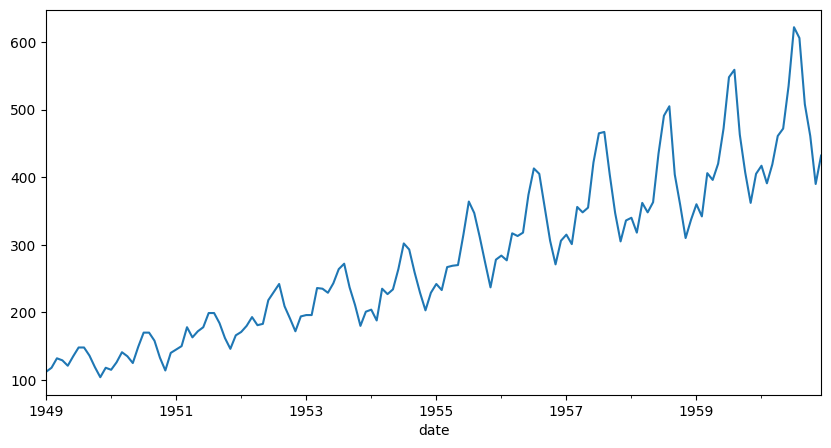

In [4]:
passengers['num_passengers'].plot(figsize=(10,5))
plt.show()

In [55]:
def approximate_ADDITIVE_SEASONALITY_HOLTWINTERS(alpha=0.4, beta=0.03, gamma=0.75, s=12, column='num_passengers'):
    level = np.full(passengers.shape[0], 0.)
    level[s-1] = passengers[column].values[s-1]

    mean_s = np.mean(passengers[column].values[0:s])
    
    trend = np.full(passengers.shape[0], 0.)
    trend[s-1] = np.mean(passengers[column].values[s:2*s]) - mean_s

    seasonal = np.full(passengers.shape[0], 0.)
    seasonal[0:s] = passengers[column].values[0:s] - mean_s
    
    y_hat = np.full(passengers.shape[0], 0.)
    y_hat[s-1] = passengers[column].values[s-1]
    
    for i in range(s, passengers.shape[0]):
        prev_level = level[i-1]
        prev_trend = trend[i-1]
        prev_seasonal = seasonal[i-s]
        last_seasonal = seasonal[i-s+1]
        
        level[i] = alpha * (passengers[column].values[i] - prev_seasonal) + (1-alpha) * (level[i-1] + trend[i-1])
        trend[i] = beta * (level[i] - prev_level) + (1-beta) * trend[i-1]
        seasonal[i] = gamma * (passengers[column].values[i] - prev_level - prev_trend) + (1-gamma) * prev_seasonal
        y_hat[i] = level[i] + trend[i] + last_seasonal
    return y_hat, level, trend, seasonal 

In [56]:
approximation, _, _, _ = approximate_ADDITIVE_SEASONALITY_HOLTWINTERS()
approximation_df = pd.DataFrame(approximation, columns=['num_passengers'])
approximation_df.index = passengers.index

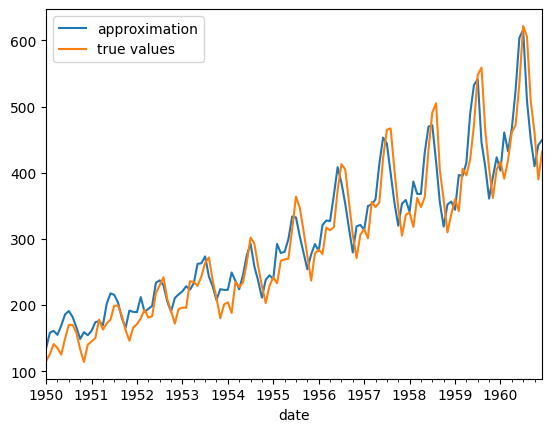

In [81]:
approximation_df['num_passengers'][12:].plot(label='approximation')
passengers['num_passengers'][12:].plot(label='true values')
plt.legend()
plt.show()

In [77]:
def get_forecast_ADDITIVE_SEASONALITY_HOLTWINTERS(alpha=0.4, beta=0.03, gamma=0.75, s=12, column='num_passengers'):
    y_hat, level, trend, seasonal = approximate_ADDITIVE_SEASONALITY_HOLTWINTERS(alpha, beta, gamma, s, column)
    for i in range(36):
        prev_level = level[-1]
        prev_trend = trend[-1]
        prev_seasonal = seasonal[-12]
        last_seasonal = seasonal[-11]

        level = np.append(level, alpha * (y_hat[-1] - prev_seasonal) + (1-alpha) * (level[-1] + trend[-1]))
        trend = np.append(trend, beta * (level[-1] - prev_level) + (1-beta) * trend[-1])
        seasonal = np.append(seasonal, gamma * (y_hat[-1] - prev_level-prev_trend) + (1-gamma) * prev_seasonal)
        y_hat = np.append(y_hat, level[-1] + trend[-1] + last_seasonal)
    return y_hat, level, trend, seasonal

In [78]:
forecast, _, _, _ = get_forecast_ADDITIVE_SEASONALITY_HOLTWINTERS()
forecast_df = pd.DataFrame(forecast, columns=['num_passengers'])
forecast_df.index = passengers.index.append(pd.date_range('1961-01-01', '1964-01-01', freq='M'))

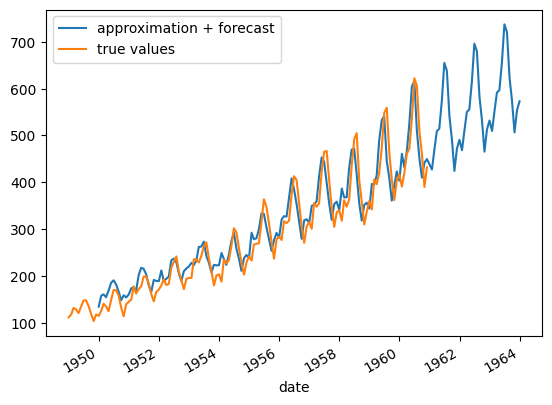

In [79]:
forecast_df['num_passengers'][12:].plot(label='approximation + forecast')
passengers['num_passengers'].plot(label='true values')
plt.legend()
plt.show()